Trabajo realizado por: Pablo Gamarro Lozano y Cristian Torres Ortega 

# Modelo de clasificación
El modelo que queremos crear tiene como objetivo predecir la gravedad de los accidentes según las condiciones del choque que encontremos interesantes dentro del dataset como el clima, el estado de la carretera, la luminosidad, que la persona hubiera consumido alcohol o drogas, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

## Carga de datos 

In [2]:
df_parties = pd.read_csv(
    "data/Traffic_Crashes_Resulting_in_Injury__Parties_Involved.csv",
    dtype={
        4: str,
        16: str
    })
df_parties.shape

(115723, 86)

## Buscar variables categóricas interesantes para el modelo
Este código ha sido ejecutado múltiples veces para ir averiguando los valóres únicos de cada columna (en caso de ser categóricas) y decidir cual o cuales serían utilizadas en el modelo. Las numéricas no se han considerado ya que el número de fallecidos o lesionados no son relevantes para estudiar como de grave es el accidente según las condiciones del choque, ya que al utilizarlas el modelo podría fijarse en ellas directamente y dar el veredicto. 

In [3]:
df_parties["type_of_collision"].unique()

array(['Vehicle/Pedestrian', 'Broadside', 'Head-On', 'Rear End', 'Other',
       'Sideswipe', 'Overturned', 'Hit Object', 'Not Stated', nan],
      dtype=object)

In [4]:
categorical_variables = df_parties.select_dtypes(exclude=np.number).iloc[:,
                                                                         60:75]
categorical_variables

special_info_g street_of_travel                    vehicle_autonomous  \
0          Not Stated    Not Collected                         Not Collected   
1          Not Stated     SCOTT STREET                         Not Collected   
2          Not Stated    Not Collected                         Not Collected   
3          Not Stated          DORE ST                         Not Collected   
4          Not Stated              NaN                         Not Collected   
...               ...              ...                                   ...   
115718     Not Stated          YORK ST                         Not Collected   
115719            NaN        SUTTER ST  Not applicable, conventional vehicle   
115720            NaN      POLK STREET  Not applicable, conventional vehicle   
115721            NaN          25TH ST  Not applicable, conventional vehicle   
115722            NaN    IRVING STREET  Not applicable, conventional vehicle   

                                point          data_loaded_at  
0        POINT (-122.45412 37.723457)  01/14/2023 03:33:06 AM  
1         POINT (-122.43556 37.77242)  01/14/2023 03:33:12 AM  
2         POINT (-122.3986 37.762455)  01/14/2023 03:33:20 AM  
3        POINT (-122.41377 37.774517)  01/14/2023 03:33:22 AM  
4          POINT (-122.402 37.778908)  01/14/2023 03:33:22 AM  
...                               ...                     ...  
115718   POINT (-122.40819 37.752853)  01/14/2023 03:36:29 AM  
115719   POINT (-122.41189 37.788807)  01/14/2023 03:36:29 AM  
115720    POINT (-122.41977 37.78589)  01/14/2023 03:36:31 AM  
115721  POINT (-122.388756 37.752777)  01/14/2023 03:36:31 AM  
115722   POINT (-122.48321 37.763294)  01/14/2023 03:36:31 AM  

[115723 rows x 5 columns]

In [5]:
categorical_variables.columns

Index(['special_info_g', 'street_of_travel', 'vehicle_autonomous', 'point',
       'data_loaded_at'],
      dtype='object')

La lista final de variables a analizar es la siguiente:

In [6]:
categoric_variables_list = [
    'weather_1', 'weather_2', 'type_of_collision', 'mviw', 'ped_action',
    'road_surface', 'road_cond_1', 'road_cond_2', 'lighting', 'intersection',
    "dph_col_grp_description", 'party_type', 'party_sobriety',
    'party_drug_physical', 'party_safety_equip_1', 'party_safety_equip_2'
]

## Chequear categóricas

In [7]:
df_parties[categoric_variables_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115723 entries, 0 to 115722
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   weather_1                115723 non-null  object
 1   weather_2                114012 non-null  object
 2   type_of_collision        115721 non-null  object
 3   mviw                     115723 non-null  object
 4   ped_action               115723 non-null  object
 5   road_surface             115723 non-null  object
 6   road_cond_1              115723 non-null  object
 7   road_cond_2              115723 non-null  object
 8   lighting                 115723 non-null  object
 9   intersection             115721 non-null  object
 10  dph_col_grp_description  115723 non-null  object
 11  party_type               115723 non-null  object
 12  party_sobriety           115723 non-null  object
 13  party_drug_physical      115723 non-null  object
 14  party_safety_equip_1

In [8]:
df_analysis = df_parties[categoric_variables_list].fillna("Not stated")
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115723 entries, 0 to 115722
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   weather_1                115723 non-null  object
 1   weather_2                115723 non-null  object
 2   type_of_collision        115723 non-null  object
 3   mviw                     115723 non-null  object
 4   ped_action               115723 non-null  object
 5   road_surface             115723 non-null  object
 6   road_cond_1              115723 non-null  object
 7   road_cond_2              115723 non-null  object
 8   lighting                 115723 non-null  object
 9   intersection             115723 non-null  object
 10  dph_col_grp_description  115723 non-null  object
 11  party_type               115723 non-null  object
 12  party_sobriety           115723 non-null  object
 13  party_drug_physical      115723 non-null  object
 14  party_safety_equip_1

## Separación en conjunto de train y test

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [10]:
predictors = df_analysis[categoric_variables_list]
target = df_parties["collision_severity"]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(predictors,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

## Creación y entrenamiento del modelo

In [12]:
save_filename = "trained_grid_tree.sav"

In [13]:
tree = DecisionTreeClassifier()
ohe = OneHotEncoder(handle_unknown='ignore')
ct = ColumnTransformer(transformers=[('cat', ohe, categoric_variables_list)])
model_pipeline = Pipeline(steps=[('preprocessor', ct), ('model', tree)])

In [14]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_1', 'weather_2',
                                                   'type_of_collision', 'mviw',
                                                   'ped_action', 'road_surface',
                                                   'road_cond_1', 'road_cond_2',
                                                   'lighting', 'intersection',
                                                   'dph_col_grp_description',
                                                   'party_type',
                                                   'party_sobriety',
                                                   'party_drug_physical',
                                                   'party_safety_equip_1',
                                                   'party_saf

In [15]:
model_pipeline.score(x_test, y_test)

0.6437243465111255

In [16]:
tree = model_pipeline["model"]
ohe = model_pipeline["preprocessor"]

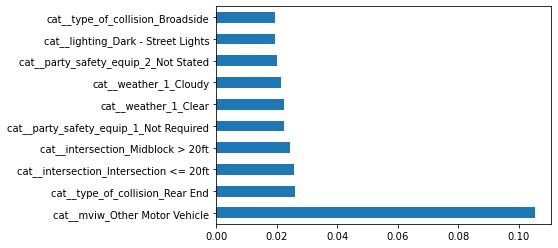

In [17]:
feat_importances = pd.Series(tree.feature_importances_,
                             index=ohe.get_feature_names_out())
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Fine Tuning

In [18]:
if not os.path.isfile(save_filename):
    params = {
        "model__min_samples_split": [10, 20],
        "model__max_depth": [6, 10, 14],
        "model__min_samples_leaf": [2, 3, 5]
    }
    my_grid = GridSearchCV(model_pipeline, params, cv=4, verbose=1)
    my_grid.fit(predictors, target)
else:
    my_grid = joblib.load(save_filename)

In [19]:
my_grid.best_score_, my_grid.best_params_

(0.6496202342431663,
 {'model__max_depth': 10,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 10})

In [20]:
best_model = my_grid.best_estimator_
best_tree = best_model["model"]
ohe_best_tree = best_model["preprocessor"]

In [21]:
from sklearn.tree import plot_tree

In [22]:
len(ohe.get_feature_names_out())

188

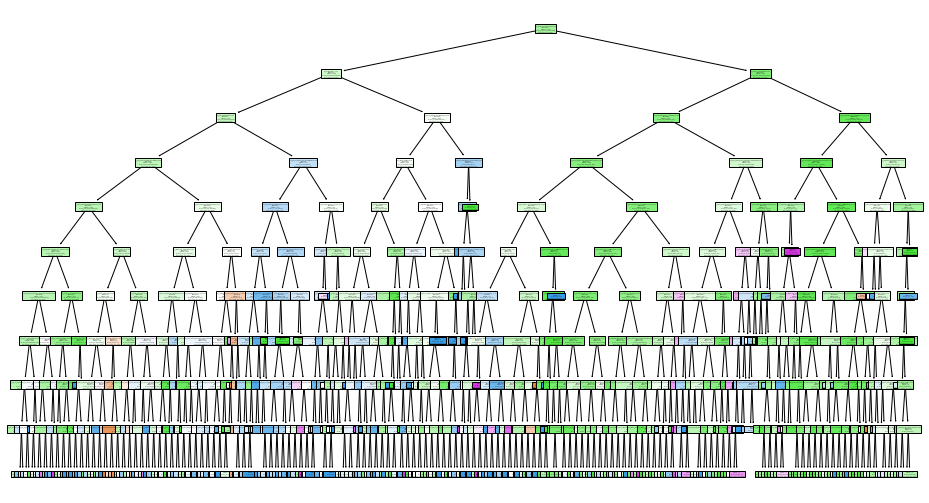

In [23]:
plt.figure(figsize=(16, 9))
plot_tree(best_tree,
          filled=True,
          feature_names=ohe_best_tree.get_feature_names_out(),
          class_names=target)
plt.savefig("Arbol.png")
plt.show()

## Guardar el modelo si no fue cargado antes

In [24]:
if not os.path.isfile(save_filename):
    best_tree_save_register = joblib.dump(my_grid, save_filename)
    print(best_tree_save_register)

# Clustering
En esta parte de la práctica, se va a analizar la información de aquellas personas culpables envueltas en el accidente para agruparlos en distintos perfiles.

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Selección de variables

In [26]:
df_parties["party_type"].unique()

array(['Pedestrian', 'Driver', 'Parked Vehicle', 'Bicyclist', 'Other'],
      dtype=object)

In [27]:
person_variables = [
    "party_type", 'party_sex', 'party_age', 'party_sobriety',
    'party_drug_physical', 'race'
]
df_clustering = df_parties[df_parties["at_fault"] == "Yes"]
df_clustering = df_clustering[person_variables]

## Selección de número de clusters
Para seleccionar el número de clusters apropiados, se utilizará el método del codo.

In [28]:
def plot_results(inertials):
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.title("Metodo del codo")
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.show()


def select_clusters(dataset, loops, max_iter=300):
    if loops < 2:
        raise ValueError("Número de iteraciones <2")
    inertia_clusters = list()
    silhouette_avgs = list()
    ohe = OneHotEncoder(handle_unknown="ignore")
    ct = ColumnTransformer(transformers=[('categorical', ohe,
                                          dataset.columns)])
    ohe_dataset = ct.fit_transform(dataset)

    # El mínimo de clusters tienen que ser 2 para poder realizar el método de la silueta
    for i in range(2, loops + 1):
        kmeans = KMeans(n_clusters=i, max_iter=max_iter)
        model_pipeline = Pipeline(steps=[('preprocessor', ct), ('model',
                                                                kmeans)])

        model_pipeline.fit(dataset)

        # SILHOUETTE METHOD

        silhouette_avg = silhouette_score(ohe_dataset,
                                          model_pipeline.predict(dataset))
        silhouette_avgs.append(silhouette_avg)

        # ELBOW METHOD
        inertia_clusters.append([i, model_pipeline["model"].inertia_])

    silhouette_avgs = list(enumerate(silhouette_avgs))
    silhouette_avgs = list(map(lambda x: (x[0] + 2, x[1]), silhouette_avgs))

    return inertia_clusters, silhouette_avgs

Loading


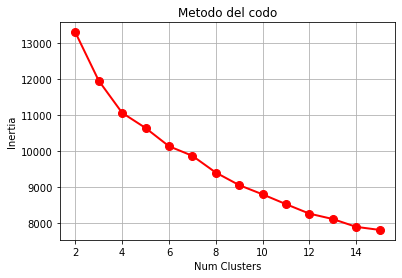

Puntuaciones silueta para N-Clusters:
(2, 0.14931729611632252)
(3, 0.16650436264016305)
(4, 0.14286888784884494)
(5, 0.1408494027566598)
(6, 0.16039358021872965)
(7, 0.15570302825145602)
(8, 0.16582804394094722)
(9, 0.14784004318768543)
(10, 0.1663811130292338)
(11, 0.17852616118937026)
(12, 0.18136385033963734)
(13, 0.19440692784404595)
(14, 0.20144789137597724)
(15, 0.2076946040006173)


In [33]:
silhouette_avgs_fname = "silhouette_avgs.sav"
inertia_fname = "inertia_clusters.sav"
n_iter = 300
n_clusters = 15  # minino 2 clusters

if not os.path.isfile(silhouette_avgs_fname) or not os.path.isfile(
        inertia_fname):
    print("Creating")

    inertia_clusters, silhouette_avgs = select_clusters(
        df_clustering, n_clusters, n_iter)

    joblib.dump(silhouette_avgs, silhouette_avgs_fname)
    joblib.dump(inertia_clusters, inertia_fname)

    plot_results(inertia_clusters)
    print("Puntuaciones silueta para N-Clusters:")
    for item in silhouette_avgs:
        print(item)
else:
    print("Loading")

    inertia_clusters = joblib.load(inertia_fname)
    silhouette_avgs = joblib.load(silhouette_avgs_fname)

    plot_results(inertia_clusters)
    print("Puntuaciones silueta para N-Clusters:")
    for item in silhouette_avgs:
        print(item)

De los resultados del método de la silueta, se ve que las puntuaciones son muy bajas como para poder aplicar clustering con cualquier número de clusters de 2 a 15.

Tras aplicar el método del codo, no se observa un número de clusters especialmente óptimo como podría haberse dado como en la siguiente imagen de ejemplo.
<img src="https://i2.wp.com/www.aprendemachinelearning.com/wp-content/uploads/2018/03/ejemplo-elbow.png?resize=768%2C422" width="700em" height="700em"></img>

In [44]:
kmeans_model_fname = "kmeans_model.sav"
kmeans_labels_fname = "kmeans_labels.sav"

if not os.path.isfile(kmeans_model_fname) or not os.path.isfile(
        kmeans_labels_fname):
    print("Creating")

    ohe = OneHotEncoder(handle_unknown="ignore")
    ct = ColumnTransformer(transformers=[('categorical', ohe,
                                          df_clustering.columns)])
    kmeans = KMeans(n_clusters=12, max_iter=100)
    model_pipeline_kmeans = Pipeline(steps=[('preprocessor',
                                             ct), ('model', kmeans)])
    result_labels = model_pipeline.fit_predict(df_clustering)
    joblib.dump(model_pipeline, kmeans_model_fname)
    joblib.dump(result_labels, kmeans_labels_fname)
else:
    print("Loading")
    model_pipeline_kmeans = joblib.load(kmeans_model_fname)
    result_labels = joblib.load(kmeans_labels_fname)
print("Done")

Loading
Done


In [51]:
df_clustering_results = pd.concat(
    [df_clustering,
     pd.DataFrame({"cluster_label": result_labels})], axis=1)
df_clustering_results.head()

party_type   party_sex  party_age         party_sobriety  \
7   Pedestrian        Male       33.0  Had Not Been Drinking   
8       Driver        Male       49.0  Had Not Been Drinking   
10      Driver        Male       66.0  Had Not Been Drinking   
15   Bicyclist        Male       22.0  Had Not Been Drinking   
23       Other  Not Stated        NaN  Had Not Been Drinking   

   party_drug_physical        race  cluster_label  
7           Not Stated       Asian            1.0  
8           Not Stated       White            0.0  
10          Not Stated       Black            3.0  
15          Not Stated       Asian            8.0  
23          Not Stated  Not Stated            4.0

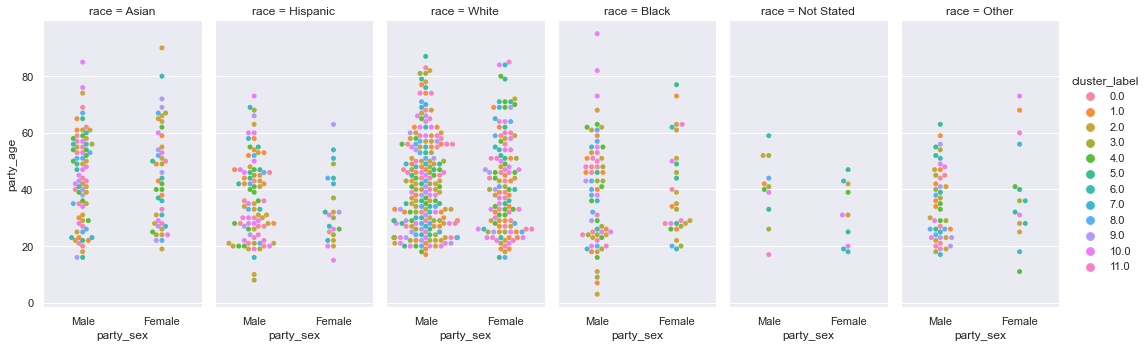

In [64]:
df_scatter = df_clustering_results[df_clustering_results["party_sex"].isin(
    ["Male", "Female"])]
df_scatter = df_scatter.sample(frac=0.04)
sns.set(rc={"figure.figsize": (16, 16)})
sns.catplot(data=df_scatter,
            kind="swarm",
            x="party_sex",
            y="party_age",
            hue="cluster_label",
            col="race",
            aspect=.5)